[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/NNDesignDeepLearning/NNDesignDeepLearning/blob/master/06.TensorFlowIntroChapter/Code/LabSolutions/TensorFlowIntroLab2_Solution.ipynb)

# TensorFlow Introduction Lab 2  -- Preventing Overfitting

This objective of this second TensorFlow lab is to test methods to help prevent the neural network models from overfitting. This is based on topics covered in Chapter 4 -- Supplemental Training Procedures, which you may want to review before running this lab. In particular, you will test the effects of using batch normalization and early stopping. In addition, you will use **data augmentation**. This is a way of increasing the size of the dataset by adding images that are realistic modifications of the original images. The larger a dataset is, the less likely the network will overfit.

When working on this lab, you may find it useful to consult websites related to [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset), which describes all of the methods that can be used with TensorFlow Datasets, and [TensorFlow Input Pipelines](https://www.tensorflow.org/guide/data).

In this lab we will use a dataset that is contained in the [TensorFlow Datasets](https://www.tensorflow.org/datasets). The datasets here can be loaded directly into the `tf.data.Datasets` format.

Another model from keras that we use in this lab is [preprocssing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing). We will use methods from this library for normalizing and augmenting data.

## Loading Modules

We begin by loading some useful modules. 

In [18]:
%matplotlib inline
!pip3 install tensorflow-datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.data import Dataset
from tensorflow.keras import datasets
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Normalization, Rescaling,RandomZoom,RandomTranslation,RandomRotation

from tensorflow.keras.losses import SparseCategoricalCrossentropy
import tensorflow as tf

Defaulting to user installation because normal site-packages is not writeable


# Loading Data

For this lab we will use a variation of the MNIST datset we used in Lab 1. This dataset, referred to as KMNIST, also consists of handwritten charaters, but they are Kanji characters. You can find a description [here](http://codh.rois.ac.jp/kmnist/index.html.en). The data can be loaded directly into a TensorFlow Dataset using the `tfds.load()` method.

When loading the data it can be split into several subsets (see [Splits&Slicing](https://www.tensorflow.org/datasets/splits)). Add the following argument to the `tfds.load()` method: `split=['train[:85%]', 'train[85%:]', 'test']`. This will return a list of three different Datasets. The first, which will have 85% of the traning set, will be used for training. The second, which will use 15% of the training set, will be used for validation. The third Dataset will contain the test set. The validation set will be passed to the fit method as `validation_data`. The performance on this set will be displayed during training, and saved in `history`, but it will not be used for weight updates. By monitoring the validation set during training, we can identify when the network is overfitting.

In [7]:
ds, ds_info = tfds.load('kmnist', split=['train[:85%]', 'train[85%:]', 'test'], as_supervised=True, with_info=True)
dstrain = ds[0]
dsval = ds[1]
dstest = ds[2]

2024-12-27 19:04:30.798229: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".
/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dl Completed...: 0 url [00:00, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|          | 0/1 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|          | 0/2 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|          | 0/3 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|          | 0/4 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|          | 0/4 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Size...:   0%|          | 0/17 [00:00<?, ? MiB/s]

Dl Size...:   0%|          | 0/19 [00:00<?, ? MiB/s]

Dl Size...:   0%|          | 0/19 [00:00<?, ? MiB/s]

Dl Size...:   0%|          | 0/19 [00:00<?, ? MiB/s]

Dl Size...:   0%|          | 0/19 [00:00<?, ? MiB/s]

Dl Size...:   0%|          | 0/19 [00:00<?, ? MiB/s]

Dl Size...:   0%|          | 0/19 [00:00<?, ? MiB/s]

Dl Size...:   0%|          | 0/19 [00:00<?, ? MiB/s]

Dl Size...:   0%|          

Dataset kmnist downloaded and prepared to /home/amir/tensorflow_datasets/kmnist/3.0.1. Subsequent calls will reuse this data.


You can see a sample of the dataset with the following command. 

2024-12-27 19:05:00.133278: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-12-27 19:05:00.143622: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


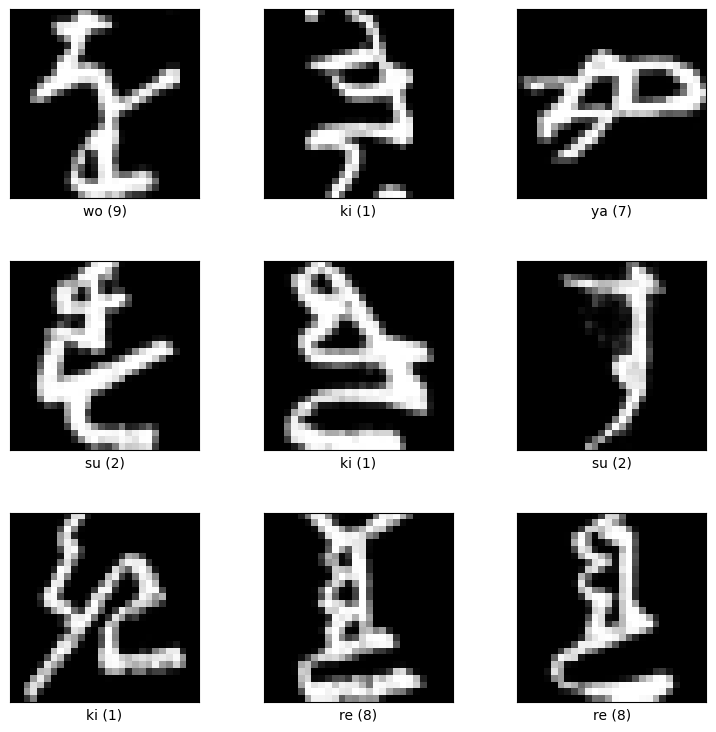

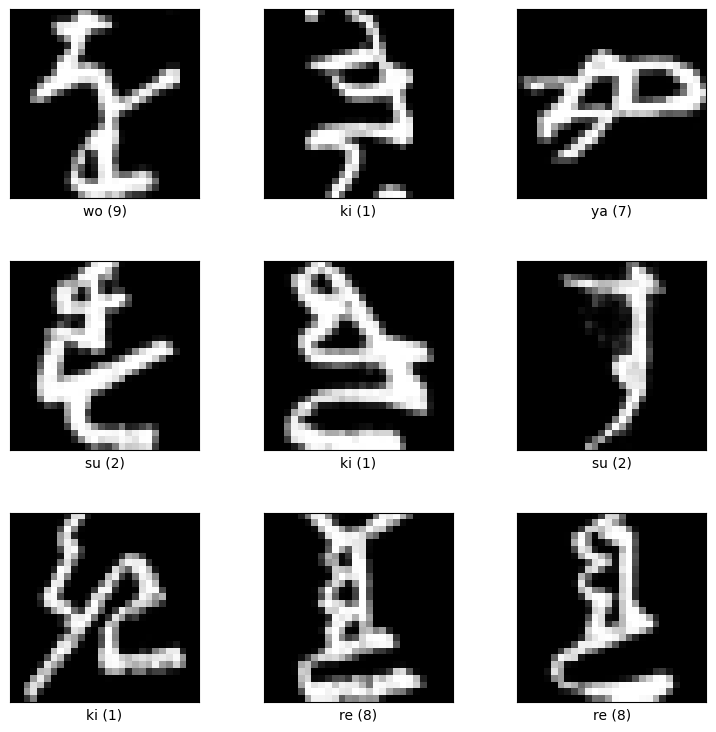

In [8]:
tfds.visualization.show_examples(dstrain, ds_info)

# Normalization

As in the first lab, it is helpful to normalize the input images before training. Since the data is in a Dataset, we can create a normalization function and then use the `map()` method to apply it to the Dataset. 

First, create a normalization model, using `models.Sequential()` and `preprocessing.Rescaling()`. (See [preprocssing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing) for documentation.) As in the first lab, you want to divide the input by 255. 

In [10]:
# "preprocessing" will be replaced by "layers" in later versions of TF
norm = models.Sequential([
    Rescaling(scale=1.0 / 255)
])

Next, use the  `map()` method and a `lambda` function to apply the normalization model to the training, validation and test Datasets. In the `lambda` function there will be two arguments, the network input and the target output. Only the network input is passed through the normalization model.

In [11]:
dstrain = dstrain.map(lambda x, y: (norm(x), y))
dsval = dsval.map(lambda x, y: (norm(x), y))
dstest = dstest.map(lambda x, y: (norm(x), y))

Group the data in the training, validation and testing Datasets into minibatches of size 100, using the `batch()` method.

In [12]:
dstrain  = dstrain.batch(100)
dsval = dsval.batch(100)
dstest = dstest.batch(100)

# Create and Train the Network

Let's begin by using the make_network method from the first lab.

In [14]:
def make_model(neurons):
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28)))
    for n in neurons:
        model.add(layers.Dense(n, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    return model

Make a network with five hidden layers of 10 neurons, compile it with the `adam` optimizer, `SparseCategoricalCrossentropy()` loss and `accuracy` metric. Then train it with the default learning rate (no callbacks) for 100 epochs. (We are using `SparseCategoricalCrossentropy()` so we do not need to convert the targets to  one-hot codes.) Add the argument `validation_data=dsval` to the `model.fit()` command, so that validation loss and accuracy will be computed.

In [15]:
model = make_model([10]*5)
model.compile(optimizer='adam',loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])
history = model.fit(dstrain, epochs=100, validation_data=dsval)

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1735344328.418042 1770795 service.cc:146] XLA service 0x7783d00155c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735344328.418080 1770795 service.cc:154]   StreamExecutor device (0): NVIDIA RTX A5000 Laptop GPU, Compute Capability 8.6
2024-12-27 19:05:28.438044: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-27 19:05:28.536700: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902


163/510 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - accuracy: 0.1672 - loss: 2.1873

I0000 00:00:1735344328.984510 1770795 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


510/510 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3061 - loss: 1.8660 - val_accuracy: 0.6634 - val_loss: 0.9805
Epoch 2/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - accuracy: 0.7034 - loss: 0.9115 - val_accuracy: 0.7581 - val_loss: 0.7829
Epoch 3/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - accuracy: 0.7672 - loss: 0.7454 - val_accuracy: 0.7859 - val_loss: 0.6983
Epoch 4/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - accuracy: 0.7953 - loss: 0.6624 - val_accuracy: 0.8034 - val_loss: 0.6496
Epoch 5/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - accuracy: 0.8115 - loss: 0.6127 - val_accuracy: 0.8129 - val_loss: 0.6249
Epoch 6/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - accuracy: 0.8218 - loss: 0.5792 - val_accuracy: 0.8203 - val_loss: 0.6059
Epoch 7/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - accuracy: 0.8311 - loss: 0.5542 - val_accuracy: 0.8253 - val_loss: 0.5911
Epoch 8/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - accuracy: 0.8374 - loss: 0.5355 - val_ac

Plot the training and validation loss and accuracy, as in the first lab. The key for validation loss is `val_loss`, and the key for validation accuracy is `val_accuracy`.

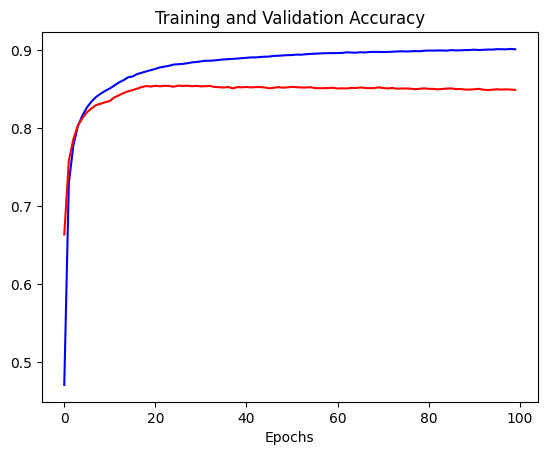

In [16]:
history_dict = history.history
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
epochs = history.epoch
plt.plot(epochs, train_acc, 'b', epochs, val_acc, 'r')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.show()

Do you see any indication of overfitting? What characteristic of the plots would indicate overfitting?

Evaluate the trained model on the test set.

In [17]:
score = model.evaluate(dstest, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.9913426041603088
Test accuracy: 0.7378000020980835


Can you improve the accuracy? Experiment with different network architectures, and see how high you can get the accuracy. Keep checking training and validation accuracy to be sure that you are not overfitting.

## Augmentation

One way to improve accuracy, while preventing overfitting, is to augment the dataset. This is a way of increasing the size of the dataset by adding images that are realistic modifications of the original images. There are several different ways to do this. You are going to perform the following steps.
1. Create an augmentation model using the `Sequential` class and methods from `preprocessing`. Use the following methods:
    1. `RandomZoom` (height_factor=(-0.05, -0.15), width_factor=(-0.05, -0.15))
    1. `RandomTranslation` (height_factor=0.02, width_factor=0.02)
    1. `RandomRotation(0.1)` (rotate randomly by 10% of 360 degrees)
1. Apply the augmentation model by using the `map()` method and a `lambda` function on the training Dataset.
1. Create a new model with your chosen architecture.
1. Pass the new augmented training Dataset to the `fit` method for training the network.

First, create the augmentation model, `trainAug`.

In [19]:
# "preprocessing" will be replaced by "layers" in later versions of TF
trainAug = models.Sequential([
	RandomZoom(
		height_factor=(-0.02, -0.05),
		width_factor=(-0.02, -0.05)),
	RandomTranslation(
		height_factor=0.02,
		width_factor=0.02),
	RandomRotation(0.05)
])

You can test this augmentation model by trying it on a sample images with the following code. You will see 9 images with different random variations.

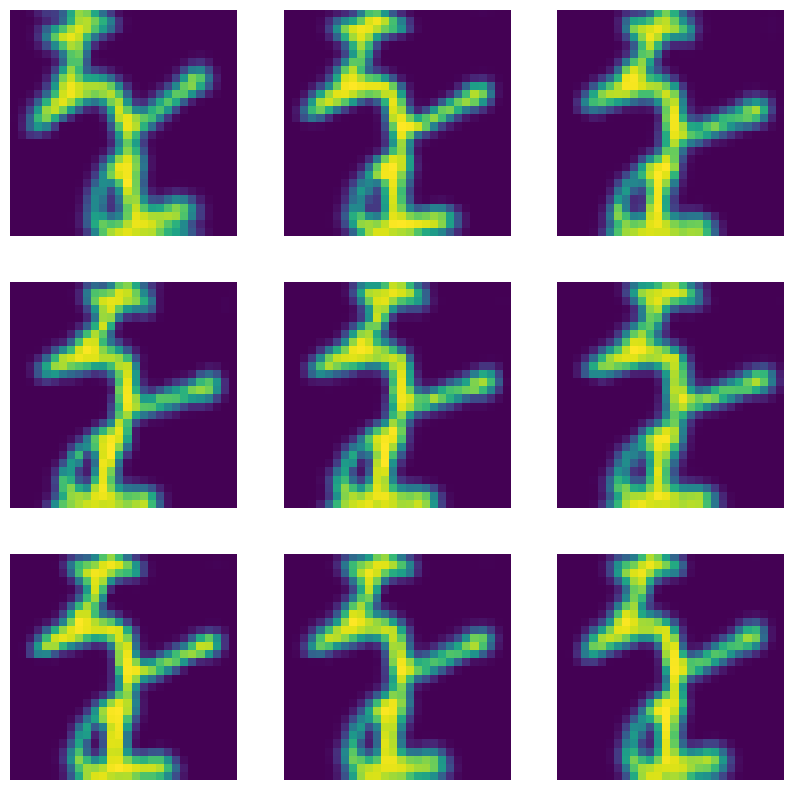

In [20]:
image, label = next(iter(ds[0]))
# Add the image to a batch
image = tf.expand_dims(image, 0)
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = trainAug(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

Next, use the  `map()` method and a `lambda` function to apply the augmentation model to the training Dataset. In the `lambda` function there will be two arguments, the network input and the target output. Only the network input is passed through the augmentation model.

In [21]:
aug_ds = dstrain.map(lambda x, y: (trainAug(x), y))

Create a model with make_model(), compile it and train it with the augmented Dataset.

In [22]:
model = make_model([10]*5)
model.compile(optimizer='adam',loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])
history = model.fit(aug_ds, epochs=100, validation_data=dsval)

Epoch 1/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.3693 - loss: 1.7606 - val_accuracy: 0.6604 - val_loss: 1.0586
Epoch 2/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6398 - loss: 1.0933 - val_accuracy: 0.7256 - val_loss: 0.8708
Epoch 3/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6996 - loss: 0.9335 - val_accuracy: 0.7644 - val_loss: 0.7708
Epoch 4/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7368 - loss: 0.8413 - val_accuracy: 0.7786 - val_loss: 0.7131
Epoch 5/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7540 - loss: 0.7896 - val_accuracy: 0.7836 - val_loss: 0.6916
Epoch 6/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7661 - loss: 0.7557 - val_accuracy: 0.7891 - val_loss: 0.6764
Epoch 7/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7707 - loss: 0.7396 - val_accuracy: 0.7900 - val_loss: 0.6614
Epoch 8/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7696 - loss: 0.7327 - val_accu

Plot the training and validation accuracy versus epochs.

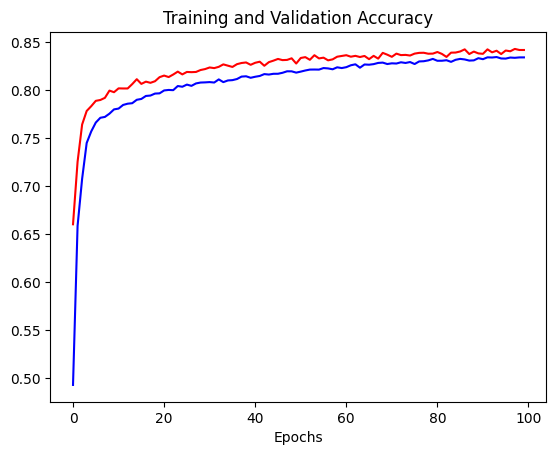

In [23]:
history_dict = history.history
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
epochs = history.epoch
plt.plot(epochs, train_acc, 'b', epochs, val_acc, 'r')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.show()

Does the network seem to be overfitting?

Use the `evalutate()` method to find the testing loss and accuracy.

In [24]:
score = model.evaluate(dstest, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.8816245198249817
Test accuracy: 0.7232000231742859


Comparing training, validation and testing accurcy, is the model overfitting? Can you add layers/neurons to improve performance. Because of augmentation, can you use larger networks without overfitting?

## Batch Normalization and Dropout

In addition to data augmentation, which enlarges the dataset, batch normalization and dropout have also been used to reduce the chances of overfitting. Batch normalization was designed to improve network convergence, but it has been found to also reduce overfitting. Dropout, as described in Chapter 4, is designed to reduce overfitting.

Both batch normalization and dropout can be implemented as keras layers (`layers.BatchNormalization()` and `layers.Dropout()`). In this section of the lab, you will experiment with adding these layers and testing their effectiveness. 

To begin, modify the `make_network()` method to incorporate dropout and/or batch normalization at the output of `Dense` layers (after the activation function) of a multilayer network (except the last layer). Put the dropout operation before batch normalization. Pass a list of arguments into the `make_model_do_bn()` method. Each element of the list should be a list containing three items: 
1. the number of neurons in the  layer, 
1. the dropout probability (see Chapter 4) (If the dropout probability is 0.0, then no dropout should be used in the layer.), 
1. a flag, `True` or `False`, indicating if batch normalization should be used in that layer. 

In [25]:
def make_model_do_bn(args):
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28)))
    for n, do, bnflag in args:
        model.add(layers.Dense(n, activation='relu'))
        if do>0:
            model.add(layers.Dropout(do))
        if bnflag:
            model.add(layers.BatchNormalization())
    model.add(layers.Dense(10, activation='softmax'))
    return model

Create a model, and check that it has the correct structure with the `summary()` method.

In [26]:
ARGS = [[10, 0.2, True], [10, 0.2, True], [10, 0, False]]
model = make_model_do_bn(ARGS)
print(model.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 10)             │         7,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │           110 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,260 (32.27 KB)

 Trainable params: 8,220 (32.11 KB)

 Non-trainable params: 40 (160.00 B)

None


# Training

Now train the network using the original training set (without augmentation). Use 5 hidden layers, with batch normalization used in each hidden layer, but without dropout in any layer. Use 20 neurons in each layer.  Train for 100 epochs, and use the validation data.

In [27]:
ARGS = [[20, 0.0, True]]*5
model = make_model_do_bn(ARGS)
model.compile(optimizer='adam',loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])
history = model.fit(dstrain, epochs=100, validation_data=dsval)

Epoch 1/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5062 - loss: 1.5207 - val_accuracy: 0.8242 - val_loss: 0.5816
Epoch 2/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8323 - loss: 0.5572 - val_accuracy: 0.8667 - val_loss: 0.4435
Epoch 3/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8670 - loss: 0.4384 - val_accuracy: 0.8832 - val_loss: 0.3960
Epoch 4/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8836 - loss: 0.3812 - val_accuracy: 0.8917 - val_loss: 0.3713
Epoch 5/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8929 - loss: 0.3484 - val_accuracy: 0.8954 - val_loss: 0.3591
Epoch 6/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9005 - loss: 0.3249 - val_accuracy: 0.8966 - val_loss: 0.3499
Epoch 7/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9054 - loss: 0.3050 - val_accuracy: 0.8988 - val_loss: 0.3433
Epoch 8/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9097 - loss: 0.2906 - val_accu

Plot the training and validation accuracy, and check for overfitting.

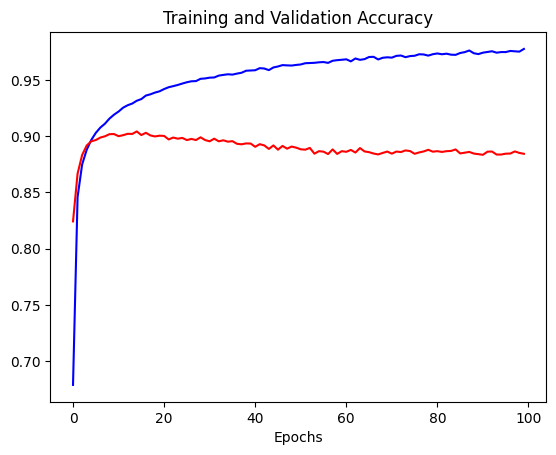

In [28]:
history_dict = history.history
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
epochs = history.epoch
plt.plot(epochs, train_acc, 'b', epochs, val_acc, 'r')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.show()

Compute the test loss and accuracy.

In [29]:
score = model.evaluate(dstest, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.4315484762191772
Test accuracy: 0.7853999733924866


Now try using dropout. Use the same network architecture, but use a dropout probability of 0.2 in each hidden layer, but do not use batch normalization.

In [30]:
ARGS = [[20, 0.2, False]]*5
model = make_model_do_bn(ARGS)
model.compile(optimizer='adam',loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])
history = model.fit(dstrain, epochs=100, validation_data=dsval)

Epoch 1/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.2650 - loss: 2.0034 - val_accuracy: 0.7113 - val_loss: 1.0300
Epoch 2/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - accuracy: 0.5747 - loss: 1.2923 - val_accuracy: 0.7669 - val_loss: 0.8068
Epoch 3/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - accuracy: 0.6484 - loss: 1.1264 - val_accuracy: 0.7922 - val_loss: 0.7390
Epoch 4/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - accuracy: 0.6825 - loss: 1.0509 - val_accuracy: 0.7942 - val_loss: 0.7181
Epoch 5/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - accuracy: 0.7029 - loss: 0.9950 - val_accuracy: 0.8040 - val_loss: 0.6879
Epoch 6/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - accuracy: 0.7077 - loss: 0.9780 - val_accuracy: 0.8087 - val_loss: 0.6825
Epoch 7/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - accuracy: 0.7214 - loss: 0.9503 - val_accuracy: 0.8083 - val_loss: 0.6733
Epoch 8/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - accuracy: 0.7261 - loss: 0.9

Plot the training and validation accuracy. Check for overfitting.

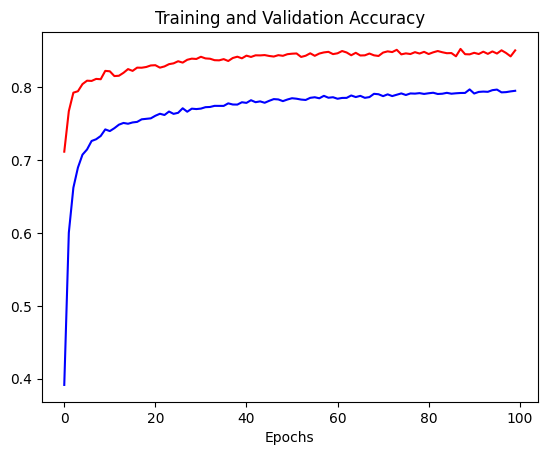

In [31]:
history_dict = history.history
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
epochs = history.epoch
plt.plot(epochs, train_acc, 'b', epochs, val_acc, 'r')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.show()

Calculate the testing loss and accuracy.

In [32]:
score = model.evaluate(dstest, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.0598357915878296
Test accuracy: 0.7064999938011169


## Explore Further

Now you know how to use augmentation, dropout and batch normalization. With these tools, see how high you can get the test accuracy by combining these approaches. You can see that there are many different options that can be tried, and remember that you can change the optimizer and the learning rate, as well as the network architecture. Don't just randomly try different combinations. Adjust one thing at a time, and see if you can determine what effect each modification has.

Here are some things to consider.

1. With your experience from the first lab, without using any of the  methods from this lab, find a network that produces the largest training accuracy.
1. Retrain the network using each of the methods introduced in this lab separately. Experiment with the dropout probability and the layers where you place dropout. Experiment with the layers where you place batch normalization. Using the methods from this lab, can  you use larger networks and increase accuracy, without overfitting?
1. After testing each method separately, start to experiment with combinations. Augmentation can be used with all other methods, but there may be combinations of dropout and batch normalization that are not as effective.
1. For each case that you try, plot the traning and validation accuracy to check for overfitting and to determine if you are training for enough iterations.